## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_max_quant()
#data_raw.head()

Now we normalize across runs.

In [2]:
from numpy import nan
from numpy import log2
from statistics import median

data_log2 = log2(data_raw.replace(0,nan))
#global_median = median(data_log2.apply(lambda series: median(series.dropna())))
data_log2_normalized = data_log2.apply(lambda series: series-median(series.dropna()))#+global_median)
data = data_log2_normalized.apply(lambda series: 2**series)

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [3]:
def check_present(row):
    bool_row = []
    for i in row:
        bool_row.append(bool(i))
    return sum(bool_row)

def check_three_of_each_type(row, cell_types=["B_cells", "T_cells"]):
    present_in_types = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        three_in_type = bool(in_type > 2)
        present_in_types.append(three_in_type)
    if sum(present_in_types) == len(cell_types):
        return True
    else: return False
    
indecies = data.apply(check_three_of_each_type, axis=1)
data = data[indecies]
#data.head()

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [4]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan

In [5]:
cell_types = ["B_cells", "T_cells"]
CVs = {}
for population in cell_types:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1, nan_policy='omit')
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    print ('nan:    \t',len([i for i in var if isnan(i)]))
    print ('Zero:    \t',len([i for i in var if i==0]))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/len(var)))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/len(var)))
    print (len(var))
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

B_cells
Mean CV:	 0.299481030368254
Min CV: 	 0.0
Max CV: 	 1.291757378358726
nan:    	 0
Zero:    	 261
Under 10%:	 312 	0.26
Under 20%:	 474 	0.40
1194

T_cells
Mean CV:	 0.2557833340070047
Min CV: 	 0.0
Max CV: 	 1.7733866296954053
nan:    	 0
Zero:    	 275
Under 10%:	 337 	0.28
Under 20%:	 519 	0.43
1194



This shows...


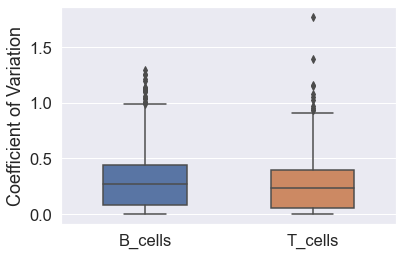

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
figure = sns.boxplot(data=CVs, width=.5)
figure.set_ylabel("Coefficient of Variation")

plt.show()